In [1]:
#ADDITIONAL DEPENDENCIES
# !pip install triangle
# !pip install rasterio
# !pip install geopy
# !pip install osmnx

In [2]:
import sys
sys.path.append(r'C:\repos\snkit\src')
sys.path.append(r'C:\repos\ra2ce')
sys.path.append(r'C:\repos\ra2ce_multi_network')
from ci_adapt_utilities import *
from matplotlib import pyplot as plt
from ra2ce_multi_network.simplify_rail import *
from ra2ce_multi_network.simplify_rail import _network_to_nx

In [3]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt_test.ini'
hazard_type, infra_type, country_code, country_name, hazard_data_subfolders, asset_data, vulnerability_data = load_config(config_file)

In [4]:
# Define paths and load data
data_path = Path(pathlib.Path(r'C:\Users\peregrin\OneDrive - Stichting Deltares\Documents\PhD Daniel Shared\Papers\Paper 1 - Adaptation Framework\Data\test'))
interim_data_path = data_path / 'interim' / 'indirect_damages'
assets, geom_dict, miraca_colors, return_period_dict, adaptation_unit_costs, rp_spec_priority, average_road_cost_per_ton_km, average_train_cost_per_ton_km, average_train_load_tons = startup_ci_adapt(data_path, config_file)


675 assets loaded.


In [5]:
# Reproject assets to match route data projection
assets_4326=assets.to_crs(4326)
assets_4326['geometry']=assets_4326['geometry'].make_valid()

In [6]:
# Load route data
route_data_source=data_path/r'input\traffic\NET_SEGMENTS_EU_EFTA_Filtered_0.xlsx'
route_data=prepare_route_data(route_data_source, assets)
route_data.head(3)

,From,To,From_Latitude,From_Longitude,To_Latitude,To_Longitude,goods,Country,geometry_from,geometry_to
3192,Büdesheim-Dromersheim,Bingen (Rhein) Stadt,49.934,7.946,49.971,7.904,1.000,DE,POINT (884511.9871012702 6434834.058730009),POINT (879858.6676332649 6441241.378778344)
3250,Bingen (Rhein) Stadt,Büdesheim-Dromersheim,49.971,7.904,49.934,7.946,1.000,DE,POINT (879858.6676332649 6441241.378778344),POINT (884511.9871012702 6434834.058730009)
4044,Langenlonsheim,Stromberg (Hunsrück),49.903,7.901,49.947,7.769,2.000,DE,POINT (879497.2043410999 6429427.441768809),POINT (864887.3582970536 6437118.144174217)


In [7]:
# Prepare network to create graph
net=Network(edges=assets_4326)
net=add_endpoints(network=net)
net=link_nodes_to_edges_within(network=net, distance=0.0000014)
net=add_ids(network=net)
net=add_topology(network=net)
net.set_crs(4326)
net.edges=net.edges.to_crs(3857)
net.nodes=net.nodes.to_crs(3857)

merged_rail_network=net

In [8]:
# Create graph from network
merged_rail_graph = _network_to_nx(merged_rail_network)

# Create a MultiDiGraph from the graph
graph_0=nx.MultiDiGraph(merged_rail_graph)

In [9]:
# Removing floats from osm_id
for u,v,k,attr in graph_0.edges(keys=True, data=True):
    if type(attr['osm_id'])==type(float()):
        graph_0[u][v][k]['osm_id'] = ''

In [10]:
# Set weights for edges
graph_0 = set_edge_weights(assets, graph_0)

In [11]:
# Set capacities for flow model
graph_0, shortest_paths = find_shortest_paths_capacities(graph_0, route_data, simplified=True)

Possible terminals: 716


Finding shortest paths between origin-destination pairs:   0%|          | 0/16 [00:00<?, ?it/s]

Failed to find paths for 0 routes


In [12]:
# Create initial virtual graph
graph_v0=create_virtual_graph(graph_0)
graph_v=graph_v0.copy()

Creating virtual graph...
Success: only int type values


In [13]:
# Load direct damages results
if 'collect_output' not in locals():
    collect_output_path = data_path/'interim/collected_flood_runs/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [14]:
# Loop through the event files and calculate the economic impact of each event
disrupted_asset_lengths={}
disrupted_shortest_paths={}
event_impacts={}
disrupted_edges_by_basin={}

for hazard_map, asset_dict in collect_output.items():
    disrupted_assets = [key for key in asset_dict.keys()]
    disrupted_osm_ids = [
        assets.loc[asset_index]['osm_id'] 
        for asset_index in disrupted_assets 
        if asset_index in assets.index and (
            (assets.loc[asset_index]['bridge'] != 'yes') 
            and (assets.loc[asset_index]['tunnel'] != 'yes')
            and (assets.loc[asset_index]['osm_id'] is not None)
            )
        ]
    if len(disrupted_osm_ids)==0:
        continue

    disrupted_edges=[]
    
    for u,v,attr in graph_0.edges(data=True):
        if 'osm_id' not in attr: 
            continue
        if attr['bridge']=='yes' or attr['tunnel']=='yes':
            continue
        matching_ids=[osm_id for osm_id in attr['osm_id'].split('; ') if osm_id in disrupted_osm_ids]
        if len(matching_ids)>0:
            disrupted_edges.append((u,v))
            
    print(f'Disrupted edges: {len(disrupted_edges)}')

    # If there are no disrupted edges in the event, move to next event
    if len(disrupted_edges)==0:
        continue
    
    disrupted_edges_by_basin[hazard_map]=disrupted_edges
    disrupted_shortest_paths[hazard_map]=calculate_new_paths(graph_v0, shortest_paths, disrupted_edges)

    if disrupted_shortest_paths[hazard_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {hazard_map}. No economic impact.')
        continue

    print('Calculating economic impact...')
    impact=calculate_economic_impact_shortest_paths(hazard_map, graph_v, shortest_paths, disrupted_shortest_paths[hazard_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    event_impacts[hazard_map]=impact
    print(hazard_map, impact)

Disrupted edges: 24
Calculating economic impact...
flood_DERP_RW_H_4326_2080430320 47481.49151079169
Disrupted edges: 78
Calculating economic impact...
flood_DERP_RW_L_4326_2080430320 14340135.635411203
Disrupted edges: 60
Calculating economic impact...
flood_DERP_RW_M_4326_2080430320 2868027.1270822403


In [15]:
#now repeat collecting all the disrupted edges accross all maps with the same return period
all_disrupted_edges={}
all_disrupted_shortest_paths={}
full_flood_event={}

haz_map_names=['flood_DERP_RW_H', 'flood_DERP_RW_M', 'flood_DERP_RW_L']

for haz_map in haz_map_names:
    all_disrupted_edges[haz_map]=[]
    for key, value in disrupted_edges_by_basin.items():
        if haz_map in key:
            all_disrupted_edges[haz_map].extend(value)
    all_disrupted_edges[haz_map]=list(set(all_disrupted_edges[haz_map]))
    print(f'Number of disrupted edges for {haz_map}: ', len(all_disrupted_edges[haz_map]))
    print('Calculating shortest paths for: ', haz_map)
    all_disrupted_shortest_paths[haz_map]=calculate_new_paths(graph_v0, shortest_paths, all_disrupted_edges[haz_map])

    if all_disrupted_shortest_paths[haz_map] == {}: # No disrupted paths, no economic impact
        print(f'No shortest paths disrupted for {haz_map}. No economic impact.')
        continue

    print('Calculating economic impact...')    
    impact=calculate_economic_impact_shortest_paths(haz_map, graph_v, shortest_paths, all_disrupted_shortest_paths[haz_map], average_train_load_tons, average_train_cost_per_ton_km, average_road_cost_per_ton_km)
    print(f'Impact for {haz_map} in M Eur: {impact/1e6 :.2f}')
    full_flood_event[haz_map]=impact

# save the data
with open(interim_data_path / 'all_disrupted_edges.pkl', 'wb') as f:
    pickle.dump(all_disrupted_edges, f)
with open(interim_data_path / 'full_flood_event.pkl', 'wb') as f:
    pickle.dump(full_flood_event, f)


Number of disrupted edges for flood_DERP_RW_H:  24
Calculating shortest paths for:  flood_DERP_RW_H
Calculating economic impact...
Impact for flood_DERP_RW_H in M Eur: 0.05
Number of disrupted edges for flood_DERP_RW_M:  60
Calculating shortest paths for:  flood_DERP_RW_M
Calculating economic impact...
Impact for flood_DERP_RW_M in M Eur: 2.87
Number of disrupted edges for flood_DERP_RW_L:  78
Calculating shortest paths for:  flood_DERP_RW_L
Calculating economic impact...
Impact for flood_DERP_RW_L in M Eur: 14.34


In [16]:
files = [file for file in os.listdir(data_path / 'interim/collected_flood_runs') if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in event_impacts.keys():
        if not str(basin) in key:
            continue
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = event_impacts[key]

for rp in return_period_dict.keys():
    # add rp as a key to all nested dictionaries with 0 as a value if the rp is not already a key
    for basin in basin_dict.keys():
        if rp not in basin_dict[basin].keys():
            basin_dict[basin][rp] = 0

basin_dict
          

{2080430320: {'_H_': 47481.49151079169,
  '_L_': 14340135.635411203,
  '_M_': 2868027.1270822403}}

In [17]:
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
# Add climate change: calculate the dynamic return periods based on flat increase factors. 
increase_factor = {
    '_H_': 2,
    '_M_': 4.21,
    '_L_': 5.86
} # Mentaschi, et al. (2016) 

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

In [18]:

aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue

    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total indirect damage'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_periods[index] for index in aggregated_df_by_basin[basin].index]
    probabilities = [[1 / rp for rp in ts] for ts in aggregated_df_by_basin[basin]['Return Period']]
    aggregated_df_by_basin[basin]['Probability'] = probabilities
    dmgs = []

    for ts in range(len(probabilities[0])):    
        dmgs_m = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities[rp][ts] - probabilities[rp + 1][ts]
            trap_damage_m = 0.5 * (aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp] + aggregated_df_by_basin[basin]['Total indirect damage'].iloc[rp + 1])
            dmgs_m.append(d_rp * trap_damage_m)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities[-1][ts]
        damage_m0 = max(aggregated_df_by_basin[basin]['Total indirect damage'])
        dmgs_m.append(d0_rp * damage_m0)

        d_end_rp = (1/4)-probabilities[0][ts]
        damage_m_end = 0.5 * min(aggregated_df_by_basin[basin]['Total indirect damage'])

        dmgs_m.append(d_end_rp * damage_m_end)

        dmgs.append((sum(dmgs_m)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total indirect damage'])


In [19]:
ead_by_ts_by_basin

{2080430320:      Total indirect damage
 0              787,353.875
 1              796,707.912
 2              806,061.950
 3              815,415.987
 4              824,770.025
 ..                     ...
 96           1,685,341.478
 97           1,694,695.515
 98           1,704,049.553
 99           1,713,403.590
 100          1,722,757.628
 
 [101 rows x 1 columns]}

In [20]:
# Find total damages by basin over the 100 y period
total_damages_by_basin = {basin: ead_by_ts_by_basin[basin].values.sum() for basin in ead_by_ts_by_basin.keys()}
total_damages_by_basin


{2080430320: 126760630.87531061}

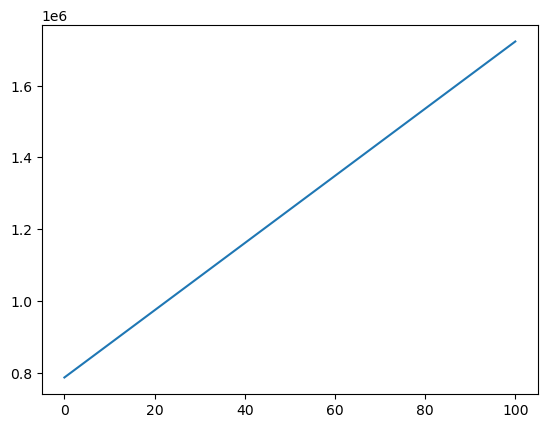

In [21]:
#plot the EAD for each basin    
for basin, ead_df in ead_by_ts_by_basin.items():
    plt.plot(ead_df, label=basin)
        

In [22]:
def georeference_damages(gdf, damages):
    # Initialize 'damage' column to 0
    gdf['damage'] = 0
    # Vectorized operation to map damages based on 'HYBAS_ID'
    damage_map = {key: value for key, value in damages.items() if key in gdf['HYBAS_ID'].tolist()}
    gdf['damage'] = gdf['HYBAS_ID'].map(damage_map).fillna(0)
    return gdf

# Load basins GeoDataFrame
basins = gpd.read_file(r'c:\Data\Floods\basins\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp')

# Assuming 'basins_list' is a predefined list of 'HYBAS_ID's to filter by
basins_filtered = basins[basins['HYBAS_ID'].isin(basins_list)]

ead_gdf = georeference_damages(basins_filtered, total_damages_by_basin)



c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [23]:
# save G and shortest paths to pickle files
pickle.dump(graph_0, open(interim_data_path / 'graph_0.pkl', 'wb'))
pickle.dump(shortest_paths, open(interim_data_path / 'shortest_paths.pkl', 'wb'))
pickle.dump(disrupted_edges_by_basin, open(interim_data_path / 'disrupted_edges_by_basin.pkl', 'wb'))
pickle.dump(disrupted_shortest_paths, open(interim_data_path / 'disrupted_shortest_paths.pkl', 'wb'))
pickle.dump(event_impacts, open(interim_data_path / 'event_impacts.pkl', 'wb'))
pickle.dump(ead_gdf, open(interim_data_path / 'ead_gdf.pkl', 'wb'))
pickle.dump(ead_by_ts_by_basin, open(interim_data_path / 'ead_by_ts_by_basin.pkl', 'wb'))
print('Data saved to pickle files.')


Data saved to pickle files.


In [24]:
def plot_shortest_paths(assets, graph, shortest_paths, colors):
    from lonboard import Map, PathLayer, ScatterplotLayer
    layers_assets=[]
    # Generate od layer for visualization
    od_geoms=[attr['geometry'] for u,attr in graph.nodes(data=True) if 'name' in attr.keys()]
    od_geoms_gdf=gpd.GeoDataFrame(geometry=od_geoms).set_crs(epsg=3857).to_crs(4326)
    
    layer_od = ScatterplotLayer.from_geopandas(od_geoms_gdf, get_fill_color=colors['red_danger'], get_radius=100, opacity=0.5, auto_highlight=False)
    # Create layer for assets for visualization
    layer_assets = PathLayer.from_geopandas(assets.drop(columns=['other_tags']), get_width=5, get_color=colors['grey_400'], auto_highlight=True, )
    layers_assets.append(layer_assets)
    # layer_shortest_path_assets = PathLayer.from_geopandas(assets_sps.drop(columns=['buffered', 'other_tags']), get_width=80, get_color=colors['black'], auto_highlight=True)
    if shortest_paths is not None:
        shortest_paths_geoms = []
        for od,(path,demand) in shortest_paths.items():
            for u in range(len(path)-1):
                edge = graph.get_edge_data(path[u], path[u+1])
                if edge is not None:
                    for i in range(len(edge)):
                        edge_data = edge[i]
                        edge_geom = edge_data['geometry']
                        shortest_paths_geoms.append((od,demand, edge_geom))
                    
        shortest_paths_gdf = gpd.GeoDataFrame(shortest_paths_geoms, columns=['od','demand', 'geometry']).set_crs(epsg=3857)
        layers_sps = PathLayer.from_geopandas(shortest_paths_gdf, get_width=8, get_color=colors['black'], auto_highlight=True)
        layers_assets.append(layers_sps)
    
    layers=[]
    if layer_assets is not None:
        layers.extend(layers_assets)
    else:
        print('No asset layer')
    Voyager = 'https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json'

    if layer_od is not None:
        layers.append(layer_od)
    else:
        print('No od layer')
    m = Map(layers, show_tooltip=True, basemap_style=Voyager, view_state={"longitude": 7.91, "latitude": 49.91, "zoom": 11})


    return m

plot_shortest_paths(assets, graph_0, shortest_paths, miraca_colors)

c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")
c:\Users\peregrin\AppData\Local\anaconda3\envs\ci_adapt_env\Lib\site-packages\lonboard\_geoarrow\ops\reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style='https://basemaps.cartocdn.com/gl/voyager-gl-style/style.json', layers=[PathLayer(auto_highl…